In [ ]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import os
import re
import random
import time
import numpy as np
import pandas as pd
import math
options = webdriver.ChromeOptions()
options.binary_location = os.environ.get( "GOOGLE_CHROME_BIN")
options.add_argument("--headless")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--no-sandbox")
options.add_argument("start-maximized");
options.add_experimental_option('excludeSwitches', ['enable-logging'])
driver = webdriver.Chrome(options=options)
driver = webdriver.Chrome(executable_path='/Users/shaytekel/Library/Mobile Documents/com~apple~CloudDocs/לימודים/פרויקט/chromedriver_mac64/chromedriver')
page_url = "https://www.ret.co.il/shop/laptop?pageindex="
driver.get(page_url + "1")
html = driver.page_source
soup = BeautifulSoup(html)
print(soup)

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html)

In [ ]:
# Scraping and crawling part

counter_laptop = 1
laptops = []

for page_number in range(1, 191):
    print(f"**** page number: {page_number}")
    response = requests.get(page_url + str(page_number))
    soup = BeautifulSoup(response.content, "html.parser")

    ol = soup.find("div", attrs={"class" : "content"})

    list_of_cards = ol.findAll("a")
    links = []
    for a in list_of_cards:
        if '/m/' in a['href']:
            links.append(a['href'])

    # run on all the laptops in this page
    for link in links:
        print(f"Laptop {counter_laptop}:")
        try:

            url = "https://www.ret.co.il" + link + "/specs"
            response = requests.get(url)
            item_web = BeautifulSoup(response.content, "html.parser") #getting the html of each laptop

        except Exception as e:
            continue


        laptop = {
            'name': np.nan,
            'company': np.nan,
            'date': np.nan,
            'weight': np.nan,
            'OS': np.nan,

            'ram': np.nan,
            'processor': np.nan,
            'processor_speed': np.nan,
            'hard_drive': np.nan,
            'hard_drive_type': np.nan,

            'screen_size': np.nan,
            'screen_resolution': np.nan,
            'screen_type': np.nan,
            'touch_screen': np.nan,
            'price': np.nan,
        }

        try:
            name = item_web.find("h1", attrs={"itemprop" : "name"}).get_text()
            laptop['name'] = name
        except Exception as e:
            print(f"Extracting Parameters :: Failed. [Parameter: name, Link: {link}]")
            print(e)

        try:
            price = int(item_web.find("meta", attrs={"itemprop" : "lowPrice"}).get('content'))
            laptop['price'] = price
        except Exception as e:
            print(f"Extracting Parameters :: Failed. [Parameter: price, Link: {link}]")
            print(e)

        rows = item_web.find("div", attrs={"class" : "single-product-tab"}).findAll("ul")

        for param_row in rows: #all the other parameters except year, those parameters inside each picture
            param_cols = param_row.findAll("li")
            key = param_cols[0].text.replace('\n', '')
            value = param_cols[1].text.replace('\n', '')
            if value ==  "לא זמין" : continue
            current_param = ""

            try:
                if "יצרן" in key:
                    current_param = 'company'
                    laptop['company'] = value
                    continue

                if "תאריך כניסה" in key:
                    current_param = 'date'
                    laptop['date'] = value
                    continue

                if "משקל" in key:
                    current_param = 'weight'
                    value = float(value.replace(' ק"ג', ''))
                    laptop['weight'] = value
                    continue

                if "מערכת הפעלה" in key:
                    current_param = 'OS'
                    laptop['OS'] = value
                    continue

                if "סוג מעבד" in key:
                    current_param = 'processor'
                    laptop['processor'] = value
                    continue

                if "נפח זיכרון RAM" in key:
                    current_param = 'ram'
                    value = re.sub("(gb|GB|Gb|\s)", "", value)
                    value = re.sub("(mb|MB|Mb|\s)", "", value)
                    value = int(value)
                    if value > 1000:
                        value = math.floor(value / 1000)
                    laptop['ram'] = value
                    continue

                if "מהירות מעבד" in key:
                    current_param = 'processor_speed'
                    value = int(re.sub("(Mhz|MHz|\s)", "", value))
                    laptop['processor_speed'] = value
                    continue

                if "כונן קשיח" in key and not "מהירות כונן קשיח" in key:
                    current_param = 'hard_drive'
                    value = int(re.sub("(gb|GB|Gb|\s)", "", value))
                    laptop['hard_drive'] = value
                    continue

                if "מהירות כונן קשיח" in key:
                    current_param = 'hard_drive_type'
                    laptop['hard_drive_type'] = value
                    continue

                if "גודל מסך" in key:
                    current_param = 'screen_size'
                    value = re.sub("(אינטש|\s)", "", value)
                    value = float(re.sub(r'[^\d\.]', '', value))
                    laptop['screen_size'] = value
                    continue

                if "רזולוציית מסך" in key:
                    current_param = 'screen_resolution'
                    laptop['screen_resolution'] = value
                    continue

                if "סוג מסך" in key:
                    current_param = 'screen_type'
                    laptop['screen_type'] = value
                    continue

                if "מסך מגע" in key:
                    current_param = 'touch_screen'
                    value = 0 if value ==  "ללא" else 1
                    laptop['touch_screen'] = value
                    continue
            except Exception as e:
                print(f"Extracting Parameters :: Failed. [Parameter: {current_param}, Link: {link}]")
                print(e)
                continue

        laptops.append(laptop)
        counter_laptop += 1


    # write to file
    try:
        page_df = pd.DataFrame(laptops)
        page_df.to_csv(f'data/crawling/laptops_{page_number}.csv', index=False)
        print(f"Save page :: Success. [Page: {page_number}]")
    except Exception as e:
        print(f"Save page :: Failed. [Page: {page_number}]")
        print(e)
        continue


    laptops = []
    time.sleep(random.randint(2,7)) # to avoid server overloading

In [ ]:
# Combine the all csv files to one
combined_df = pd.DataFrame()

for i in range(1, 71):
    file_name = f'data/crawling/laptops_{i}.csv'
    df = pd.read_csv(file_name)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Write the combined DataFrame to a CSV file
combined_df.to_csv('data/combined_laptops.csv', index=False)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def load_csv(file_name):
    return pd.read_csv(file_name)

In [40]:
dataframe = load_csv("data/laptops_merged.csv")
dataframe

,Unnamed: 0,name,company,date,weight,OS,ram,processor,processor_speed,hard_drive,hard_drive_type,screen_size,screen_type,screen_resolution,touch_screen,price
0,0,מחשב נייד Apple MacBook Air MGN93HB/A אפל,Apple,NaN,1.29,MacOS,8.0,NaN,NaN,256.0,SSD,13.3,LCD,2560x1600,0.0,3699.0
1,1,מחשב נייד Lenovo IdeaPad 3 15ITL6 82H800CSIV ל...,Lenovo,NaN,1.65,ללא,8.0,Intel Core i3,3000.0,256.0,SSD,15.6,LCD,1920x1080,0.0,1399.0
2,2,מחשב נייד Lenovo V14-ADA 82C6006AIV לנובו,Lenovo,NaN,1.60,ללא,4.0,AMD,1200.0,256.0,SSD,14.0,LCD,1366x768,0.0,750.0
3,3,מחשב נייד Apple MacBook Air 13 MGN63HB/A אפל,Apple,NaN,1.29,MacOS,8.0,NaN,NaN,256.0,SSD,13.3,LCD,2560x1600,0.0,3484.0
4,4,מחשב נייד Dell Vostro 3510 V3510-6002 דל,Dell,NaN,1.69,ללא,8.0,Intel Core i5,2400.0,256.0,SSD,15.6,LCD,1920x1080,0.0,1876.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,43,מחשב נייד Lenovo ThinkPad P53 20QN0007IV לנובו,Lenovo,NaN,2.50,Windows 10,32.0,Intel Core i7,2600.0,1000.0,NaN,15.6,IPS,3840x2160,0.0,15472.0
3356,44,מחשב נייד Asus ROG Zephyrus Duo 16 GX650RX-LO1...,Asus,NaN,2.60,NaN,64.0,AMD Ryzen 9,3300.0,NaN,NaN,16.0,LCD,2560x1600,0.0,20290.0
3357,45,מחשב נייד Asus ROG Strix Scar 17 SE G733CX-LL0...,Asus,NaN,NaN,NaN,64.0,Intel Core i9,NaN,NaN,NaN,17.3,LCD,2560x1440,0.0,22793.0
3358,46,מחשב נייד Lenovo Legion Pro 7 16IRX8H 82WQ004F...,Lenovo,NaN,NaN,NaN,32.0,Intel Core i9,NaN,NaN,NaN,16.0,IPS,2560x1600,0.0,15350.0


In [41]:
# change the columns with value ללא to NaN
dataframe = dataframe.replace('ללא', np.nan)
dataframe

,Unnamed: 0,name,company,date,weight,OS,ram,processor,processor_speed,hard_drive,hard_drive_type,screen_size,screen_type,screen_resolution,touch_screen,price
0,0,מחשב נייד Apple MacBook Air MGN93HB/A אפל,Apple,NaN,1.29,MacOS,8.0,NaN,NaN,256.0,SSD,13.3,LCD,2560x1600,0.0,3699.0
1,1,מחשב נייד Lenovo IdeaPad 3 15ITL6 82H800CSIV ל...,Lenovo,NaN,1.65,NaN,8.0,Intel Core i3,3000.0,256.0,SSD,15.6,LCD,1920x1080,0.0,1399.0
2,2,מחשב נייד Lenovo V14-ADA 82C6006AIV לנובו,Lenovo,NaN,1.60,NaN,4.0,AMD,1200.0,256.0,SSD,14.0,LCD,1366x768,0.0,750.0
3,3,מחשב נייד Apple MacBook Air 13 MGN63HB/A אפל,Apple,NaN,1.29,MacOS,8.0,NaN,NaN,256.0,SSD,13.3,LCD,2560x1600,0.0,3484.0
4,4,מחשב נייד Dell Vostro 3510 V3510-6002 דל,Dell,NaN,1.69,NaN,8.0,Intel Core i5,2400.0,256.0,SSD,15.6,LCD,1920x1080,0.0,1876.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,43,מחשב נייד Lenovo ThinkPad P53 20QN0007IV לנובו,Lenovo,NaN,2.50,Windows 10,32.0,Intel Core i7,2600.0,1000.0,NaN,15.6,IPS,3840x2160,0.0,15472.0
3356,44,מחשב נייד Asus ROG Zephyrus Duo 16 GX650RX-LO1...,Asus,NaN,2.60,NaN,64.0,AMD Ryzen 9,3300.0,NaN,NaN,16.0,LCD,2560x1600,0.0,20290.0
3357,45,מחשב נייד Asus ROG Strix Scar 17 SE G733CX-LL0...,Asus,NaN,NaN,NaN,64.0,Intel Core i9,NaN,NaN,NaN,17.3,LCD,2560x1440,0.0,22793.0
3358,46,מחשב נייד Lenovo Legion Pro 7 16IRX8H 82WQ004F...,Lenovo,NaN,NaN,NaN,32.0,Intel Core i9,NaN,NaN,NaN,16.0,IPS,2560x1600,0.0,15350.0


<AxesSubplot:xlabel='processor_speed', ylabel='price'>

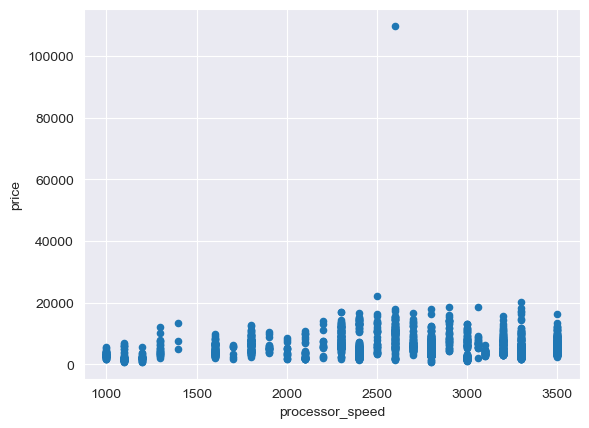

In [42]:
ax2 = dataframe.plot.scatter(x='processor_speed', y='price')
ax2

<AxesSubplot:>

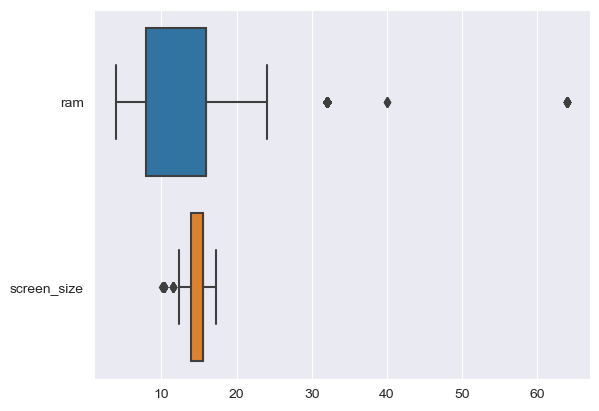

In [43]:
sns.boxplot(data=dataframe[['ram' , 'screen_size' , ]], orient="h")

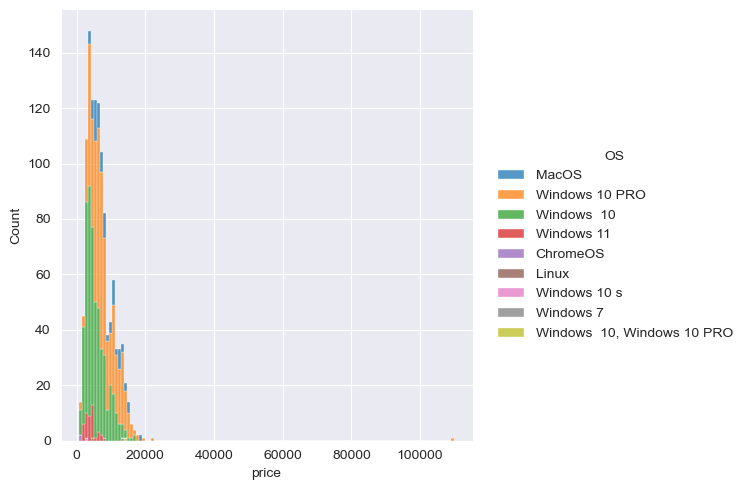

In [44]:
sns.displot(dataframe, x="price", hue='OS', multiple="stack")

<AxesSubplot:>

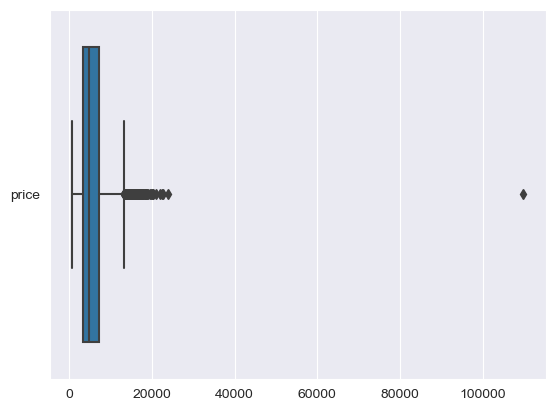

In [45]:
sns.boxplot(data=dataframe[['price']], orient="h")

In [46]:
# missing values
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3360 non-null   int64  
 1   name               3360 non-null   object 
 2   company            3336 non-null   object 
 3   date               0 non-null      float64
 4   weight             2877 non-null   float64
 5   OS                 1164 non-null   object 
 6   ram                3113 non-null   float64
 7   processor          3048 non-null   object 
 8   processor_speed    2593 non-null   float64
 9   hard_drive         1372 non-null   float64
 10  hard_drive_type    1366 non-null   object 
 11  screen_size        3057 non-null   float64
 12  screen_type        3040 non-null   object 
 13  screen_resolution  2946 non-null   object 
 14  touch_screen       3106 non-null   float64
 15  price              3358 non-null   float64
dtypes: float64(8), int64(1),

In [47]:
# As you can see in the date, os, hard_drive and hard_drive_type columns many data are missing.
# date column we will remove.
# The data in OS column we will fill intelligently.
# The hard_drive and hard_drive_type columns will be handled in the next section

df1 = dataframe.copy()

# if there is no company name we can delete it:
df1.dropna(subset=['company'], inplace=True)

# if there is no processor we can delete the row
# df1.dropna(subset=['processor'], inplace=True)
freq_processor = df1['processor'].mode()[0]  #the most frequent processor
# processor, fill with the most common
df1['processor'] = df1['processor'].fillna(freq_processor)

# if there is no price we can delete the row
df1.dropna(subset=['price'], inplace=True)

#the mean of weight
freq_processor_speed = df1['processor_speed'].mode()[0]  #the most frequent processor speed
# processor speed, fill with the most common
df1['processor_speed'] = df1['processor_speed'].fillna(freq_processor_speed)

# If there is no date and the company is not Apple, we will fill it with Windows
mask = (df1['OS'].isna()) & (df1['company'] != 'Apple')
df1.loc[mask, 'OS'] = 'Windows'
df1['OS'] = df1['OS'].str.replace('Windows.*', 'Windows')

#the average of weight
new_weight = df1['weight'].fillna(df1['weight'].median())
df1['weight'] = df1['weight'].fillna(new_weight)

#the median of weight
ram = df1['ram'].fillna(df1['ram'].median())
df1['ram'] = df1['ram'].fillna(ram)

#if there is no screen size type we can delete it
df1.dropna(subset=['screen_size'], inplace=True)

#if there is no screen type we can delete it
df1.dropna(subset=['screen_type'], inplace=True)

#the most frequent touch screen
touch_screen = df1['touch_screen'].mode()[0]
df1['touch_screen'] = df1['touch_screen'].fillna(touch_screen)

#if there is no screen resolution type we can delete it
df1.dropna(subset=['screen_resolution'], inplace=True)

df1[['height_resolution', 'width_resolution']] = df1['screen_resolution'].str.split('(?i)x', expand=True)
df1['height_resolution'] = df1['height_resolution'].astype('float64')
df1['width_resolution'] = df1['width_resolution'].astype('float64')

df1 = df1.drop(columns=['Unnamed: 0', 'name', 'screen_resolution','date'], axis=1)

df1

/var/folders/8k/ztmpkwxd2pvc_5cxcl8vwvnm0000gn/T/ipykernel_97472/307617544.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['OS'] = df1['OS'].str.replace('Windows.*', 'Windows')


,company,weight,OS,ram,processor,processor_speed,hard_drive,hard_drive_type,screen_size,screen_type,touch_screen,price,height_resolution,width_resolution
0,Apple,1.29,MacOS,8.0,Intel Core i7,2400.0,256.0,SSD,13.3,LCD,0.0,3699.0,2560.0,1600.0
1,Lenovo,1.65,Windows,8.0,Intel Core i3,3000.0,256.0,SSD,15.6,LCD,0.0,1399.0,1920.0,1080.0
2,Lenovo,1.60,Windows,4.0,AMD,1200.0,256.0,SSD,14.0,LCD,0.0,750.0,1366.0,768.0
3,Apple,1.29,MacOS,8.0,Intel Core i7,2400.0,256.0,SSD,13.3,LCD,0.0,3484.0,2560.0,1600.0
4,Dell,1.69,Windows,8.0,Intel Core i5,2400.0,256.0,SSD,15.6,LCD,0.0,1876.0,1920.0,1080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353,Lenovo,2.87,Windows,16.0,Intel Core i9,2600.0,NaN,NaN,15.6,IPS,1.0,15188.0,1920.0,1080.0
3355,Lenovo,2.50,Windows,32.0,Intel Core i7,2600.0,1000.0,NaN,15.6,IPS,0.0,15472.0,3840.0,2160.0
3356,Asus,2.60,Windows,64.0,AMD Ryzen 9,3300.0,NaN,NaN,16.0,LCD,0.0,20290.0,2560.0,1600.0
3357,Asus,1.65,Windows,64.0,Intel Core i9,2400.0,NaN,NaN,17.3,LCD,0.0,22793.0,2560.0,1440.0


In [48]:
# Since there are many missing data in hard_drive and hard_drive_type, we will investigate two scenarios:
# 1 - delete the missing rows
# 2 - delete the both features

# TODO: choose scenario
scenario = 2
if scenario == 1:
    df1.dropna(subset=['hard_drive_type'], inplace=True)
    df1.dropna(subset=['hard_drive'], inplace=True)
else:
    df1 = df1.drop(columns=['hard_drive_type', 'hard_drive'], axis=1)
df1

,company,weight,OS,ram,processor,processor_speed,screen_size,screen_type,touch_screen,price,height_resolution,width_resolution
0,Apple,1.29,MacOS,8.0,Intel Core i7,2400.0,13.3,LCD,0.0,3699.0,2560.0,1600.0
1,Lenovo,1.65,Windows,8.0,Intel Core i3,3000.0,15.6,LCD,0.0,1399.0,1920.0,1080.0
2,Lenovo,1.60,Windows,4.0,AMD,1200.0,14.0,LCD,0.0,750.0,1366.0,768.0
3,Apple,1.29,MacOS,8.0,Intel Core i7,2400.0,13.3,LCD,0.0,3484.0,2560.0,1600.0
4,Dell,1.69,Windows,8.0,Intel Core i5,2400.0,15.6,LCD,0.0,1876.0,1920.0,1080.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3353,Lenovo,2.87,Windows,16.0,Intel Core i9,2600.0,15.6,IPS,1.0,15188.0,1920.0,1080.0
3355,Lenovo,2.50,Windows,32.0,Intel Core i7,2600.0,15.6,IPS,0.0,15472.0,3840.0,2160.0
3356,Asus,2.60,Windows,64.0,AMD Ryzen 9,3300.0,16.0,LCD,0.0,20290.0,2560.0,1600.0
3357,Asus,1.65,Windows,64.0,Intel Core i9,2400.0,17.3,LCD,0.0,22793.0,2560.0,1440.0


In [49]:
df1.info()
columns = df1.select_dtypes(include=["object", "category"]).columns.tolist()
columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 0 to 3358
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company            2871 non-null   object 
 1   weight             2871 non-null   float64
 2   OS                 2871 non-null   object 
 3   ram                2871 non-null   float64
 4   processor          2871 non-null   object 
 5   processor_speed    2871 non-null   float64
 6   screen_size        2871 non-null   float64
 7   screen_type        2871 non-null   object 
 8   touch_screen       2871 non-null   float64
 9   price              2871 non-null   float64
 10  height_resolution  2871 non-null   float64
 11  width_resolution   2871 non-null   float64
dtypes: float64(8), object(4)
memory usage: 291.6+ KB


['company', 'OS', 'processor', 'screen_type']

In [50]:
unique = df1['OS'].unique()
unique

array(['MacOS', 'Windows', 'ChromeOS', 'Linux'], dtype=object)

In [51]:
df1.to_csv("data/laptops_delete_missing_data.csv")

In [52]:
# outliers

In [53]:
def outlier(df):
    df = df1.copy()
    numerical_ = ['processor_speed', 'price', 'ram']
    for i in numerical_:
        Q1 = np.percentile(df[i], 25)  #25
        Q3 = np.percentile(df[i], 75)  #75
        IQR = Q3 - Q1
        df[i][(df[i] < Q1 - 1.5 * IQR) | (df[i] > Q3 + 1.5 * IQR)] = np.nan
    return df

In [54]:
# deleting outliers :

df1 = outlier(df1)

df1.dropna(subset=['processor_speed'],inplace=True)

df1.dropna(subset=['price'],inplace=True)

df1.dropna(subset=['ram'], inplace=True)
df1

/var/folders/8k/ztmpkwxd2pvc_5cxcl8vwvnm0000gn/T/ipykernel_97472/3934894634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][(df[i] < Q1 - 1.5 * IQR) | (df[i] > Q3 + 1.5 * IQR)] = np.nan
/var/folders/8k/ztmpkwxd2pvc_5cxcl8vwvnm0000gn/T/ipykernel_97472/3934894634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][(df[i] < Q1 - 1.5 * IQR) | (df[i] > Q3 + 1.5 * IQR)] = np.nan
/var/folders/8k/ztmpkwxd2pvc_5cxcl8vwvnm0000gn/T/ipykernel_97472/3934894634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

,company,weight,OS,ram,processor,processor_speed,screen_size,screen_type,touch_screen,price,height_resolution,width_resolution
0,Apple,1.29,MacOS,8.0,Intel Core i7,2400.0,13.3,LCD,0.0,3699.0,2560.0,1600.0
1,Lenovo,1.65,Windows,8.0,Intel Core i3,3000.0,15.6,LCD,0.0,1399.0,1920.0,1080.0
3,Apple,1.29,MacOS,8.0,Intel Core i7,2400.0,13.3,LCD,0.0,3484.0,2560.0,1600.0
4,Dell,1.69,Windows,8.0,Intel Core i5,2400.0,15.6,LCD,0.0,1876.0,1920.0,1080.0
5,Apple,1.24,MacOS,8.0,Intel Core i7,2400.0,13.3,LED,0.0,4699.0,2560.0,1600.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3283,Dell,1.50,Windows,16.0,Intel Core i7,3000.0,15.0,LCD,1.0,10878.0,1920.0,1080.0
3286,Asus,2.30,Windows,16.0,AMD Ryzen 7,3200.0,15.6,IPS,0.0,11576.0,1920.0,1080.0
3291,Dell,1.96,Windows,16.0,Intel Core i7,2300.0,15.6,OLED,1.0,12160.0,3456.0,2160.0
3296,Asus,1.90,Windows,16.0,AMD Ryzen 9,3300.0,15.6,IPS,0.0,9790.0,2560.0,1440.0


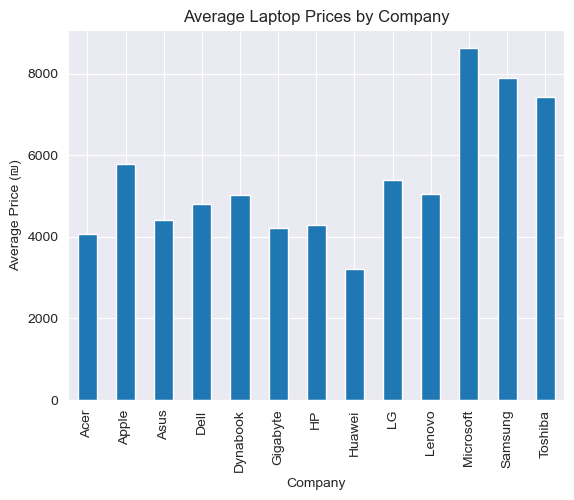

In [55]:
# Plot the average prices by Company as a bar chart
avg_price_by_company = df1.groupby('company')['price'].mean()

avg_price_by_company.plot(kind='bar')

plt.title('Average Laptop Prices by Company')
plt.xlabel('Company')
plt.ylabel('Average Price (₪)')

plt.show()

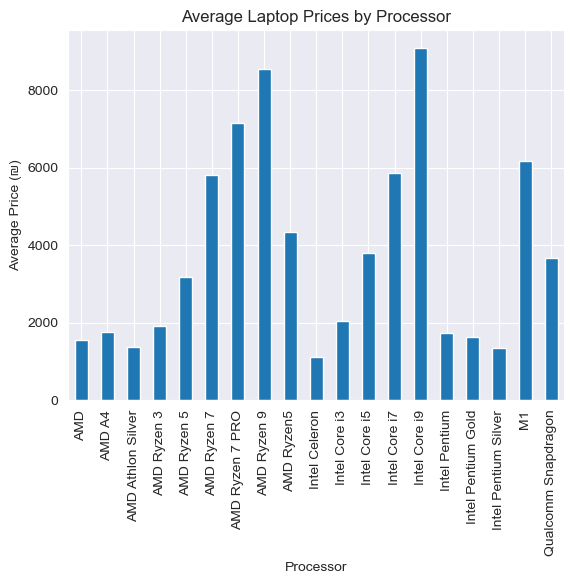

In [56]:
# Plot the average prices by Processor as a bar chart
avg_price_by_company = df1.groupby('processor')['price'].mean()

avg_price_by_company.plot(kind='bar')

plt.title('Average Laptop Prices by Processor')
plt.xlabel('Processor')
plt.ylabel('Average Price (₪)')

plt.show()

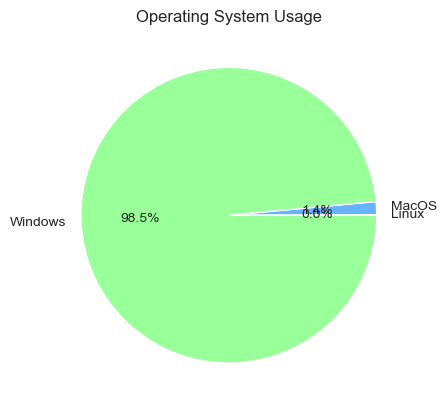

In [57]:
# show the
# sns.displot(df1, x="OS", height=8, aspect=2)
# plt.pie(df['Count'], labels=df['OS'], autopct='%1.1f%%')
os_counts = df1.groupby('OS').size()
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFFF99']

# create a pie chart with custom colors
plt.pie(os_counts, labels=os_counts.index, autopct='%1.1f%%', colors=colors)

# set the title
plt.title('Operating System Usage')

# show the plot
plt.show()

<AxesSubplot:>

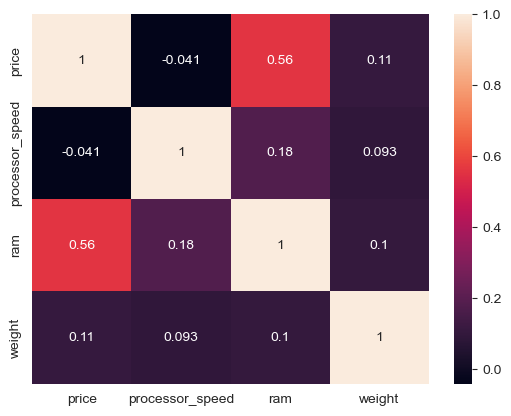

In [58]:
dff=df1[['price' ,'processor_speed' , 'ram' , 'weight']]
sns.heatmap(dff.corr() , annot = True)

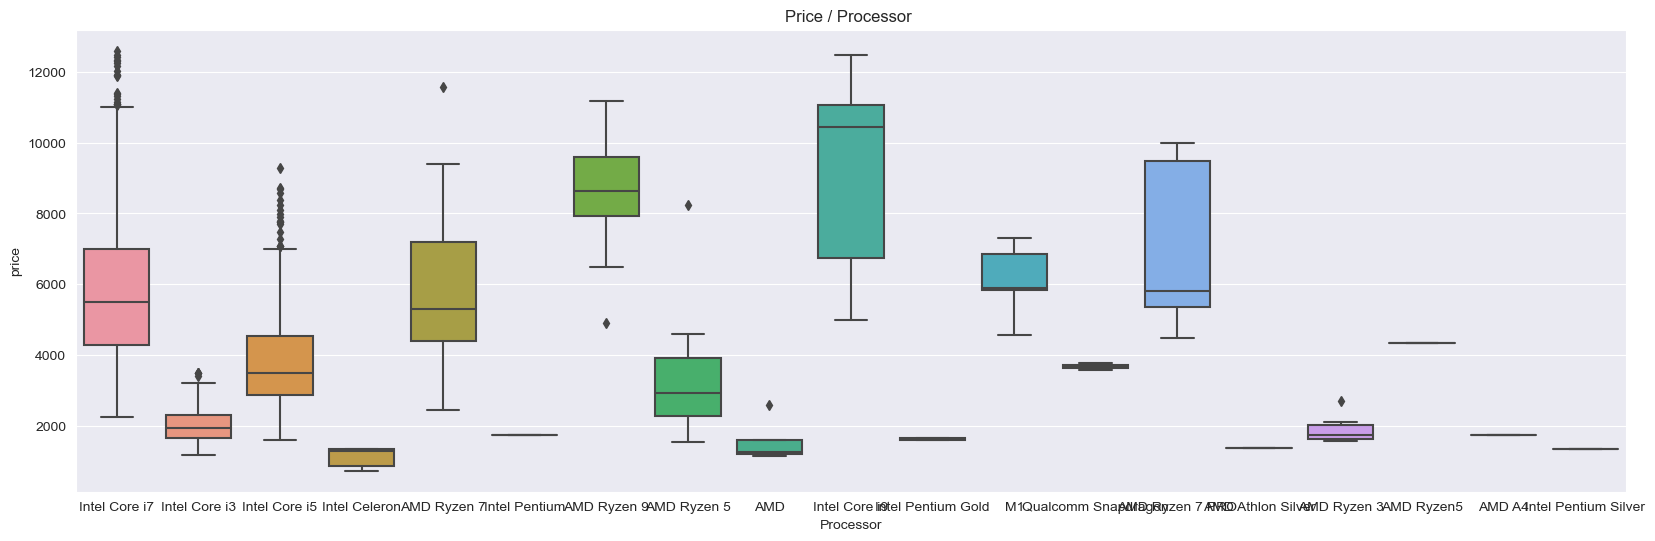

In [59]:
# boxplot featuring processor and price
fig, ax = plt.subplots(figsize=(20, 6))

fg = sns.boxplot(data=df1, x='processor', y='price')

fg.set_title("Price / Processor ")

fg.set_xlabel("Processor")

fg.set_ylabel("price")

plt.show()

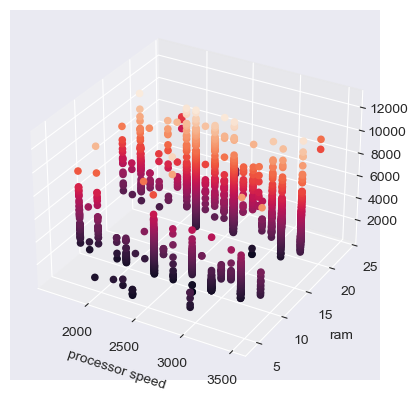

In [60]:
ax = plt.axes(projection='3d')
xdata = df1['processor_speed']
ydata = df1['ram']
zdata = df1['price']
plt.xlabel('processor speed')
plt.ylabel('ram')
ax.scatter3D(xdata , ydata , zdata , c=zdata , depthshade=False)

In [61]:
# Machine Learning part

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


In [62]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2302 entries, 0 to 3299
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company            2302 non-null   object 
 1   weight             2302 non-null   float64
 2   OS                 2302 non-null   object 
 3   ram                2302 non-null   float64
 4   processor          2302 non-null   object 
 5   processor_speed    2302 non-null   float64
 6   screen_size        2302 non-null   float64
 7   screen_type        2302 non-null   object 
 8   touch_screen       2302 non-null   float64
 9   price              2302 non-null   float64
 10  height_resolution  2302 non-null   float64
 11  width_resolution   2302 non-null   float64
dtypes: float64(8), object(4)
memory usage: 233.8+ KB


In [63]:
columns = df1.select_dtypes(include=["object", "category"]).columns.tolist()
df_linear = pd.get_dummies(df1, columns=columns, drop_first=True)
df_linear

,weight,ram,processor_speed,screen_size,touch_screen,price,height_resolution,width_resolution,company_Apple,company_Asus,...,processor_Intel Core i9,processor_Intel Pentium,processor_Intel Pentium Gold,processor_Intel Pentium Silver,processor_M1,processor_Qualcomm Snapdragon,screen_type_LCD,screen_type_LED,screen_type_OLED,screen_type_QLED
0,1.29,8.0,2400.0,13.3,0.0,3699.0,2560.0,1600.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1.65,8.0,3000.0,15.6,0.0,1399.0,1920.0,1080.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.29,8.0,2400.0,13.3,0.0,3484.0,2560.0,1600.0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1.69,8.0,2400.0,15.6,0.0,1876.0,1920.0,1080.0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,1.24,8.0,2400.0,13.3,0.0,4699.0,2560.0,1600.0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,1.50,16.0,3000.0,15.0,1.0,10878.0,1920.0,1080.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3286,2.30,16.0,3200.0,15.6,0.0,11576.0,1920.0,1080.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3291,1.96,16.0,2300.0,15.6,1.0,12160.0,3456.0,2160.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3296,1.90,16.0,3300.0,15.6,0.0,9790.0,2560.0,1440.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# split the data for training and test

scaler = StandardScaler()

TRAINING_FEATURES = df_linear.columns[df_linear.columns != 'price']
TARGET_FEATURE = 'price'

X = df_linear[TRAINING_FEATURES]
y = df_linear[TARGET_FEATURE]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
scaler.fit_transform(X_train)  # fitting the scaler
scaler.transform(X_test)

array([[ 0.20423899,  0.73014764, -2.03739309, ..., -0.29129989,
        -0.25086456, -0.02331262],
       [ 0.1769508 ,  0.73014764,  0.21072423, ...,  3.43288832,
        -0.25086456, -0.02331262],
       [-1.05101779,  0.73014764, -0.60677298, ..., -0.29129989,
        -0.25086456, -0.02331262],
       ...,
       [ 0.06779804,  0.73014764,  1.23259573, ..., -0.29129989,
        -0.25086456, -0.02331262],
       [-0.04135473,  0.73014764,  1.23259573, ..., -0.29129989,
        -0.25086456, -0.02331262],
       [ 0.36796814,  0.73014764,  0.21072423, ..., -0.29129989,
        -0.25086456, -0.02331262]])

In [66]:
# Linear machine learning - process and results:

clf_model = LinearRegression().fit(X_train, y_train)

y_predicted = clf_model.predict(X_test)

resDF = pd.DataFrame({"Actual": y_test, "Predicted": y_predicted})

resDF

,Actual,Predicted
1213,3390.0,6009.517096
1818,3310.0,5367.717517
2760,3316.0,5444.568703
1672,4999.0,6476.039816
584,5640.0,3816.169137
...,...,...
2453,6983.0,6016.725487
615,2236.0,3247.868886
1513,3390.0,3602.390983
944,3973.0,3605.382169


In [67]:
evaluate_value = r2_score(y_test, y_predicted)

evaluate_value

0.6033356569273736

In [68]:
print(X_test.size)
print(y_predicted.size)

19823
461


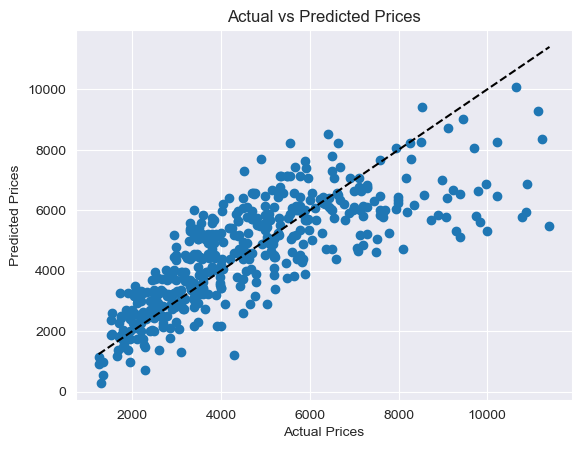

In [69]:
# Create scatter plot of predicted vs actual values
plt.scatter(y_test, y_predicted)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')

# Add a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')

plt.show()

In [70]:
# Calculate mean squared error
mse = mean_squared_error(y_test, y_predicted)
print('Mean squared error:', mse)

# Calculate coefficient of determination
r2 = r2_score(y_test, y_predicted)
print('Coefficient of determination:', r2)

Mean squared error: 1787984.680078938
Coefficient of determination: 0.6033356569273736


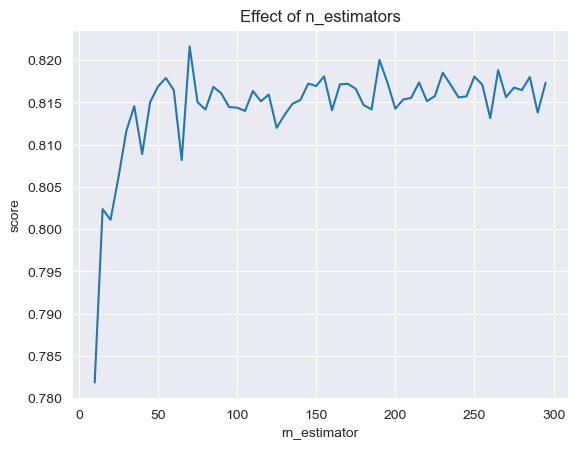

In [71]:

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_jobs=-1)

estimators = np.arange(10, 300, 5)

scores = []

# using a simple plot , we can see what is the number of n estimators which is best :

maximum_n_esimators = -1

max_score = -1

for n in estimators:

    model.set_params(n_estimators=n)

    model.fit(X_train, y_train)

    scores.append(model.score(X_test, y_test))


    current_score = model.score(X_test, y_test)  # keeping the best result

    if current_score > max_score:

        maximum_n_esimators = n

        max_score = current_score



# # we can also see the effect of n_estimators on the score of the trained model

plt.title("Effect of n_estimators")

plt.xlabel("rn_estimator")

plt.ylabel("score")

plt.plot(estimators, scores)

In [72]:
print( "The max score is:" , max_score)


The max score is: 0.8216070077036901
